<a href="https://colab.research.google.com/github/fuyan2/ML_research/blob/master/simple_gan_notebooks/simple_gan_inversion_beta0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

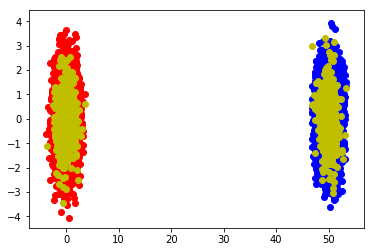

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

tf.reset_default_graph()
tf.set_random_seed(1)

# Training Params
num_steps = 100000
learning_rate = 0.00004
x_dim = 2
noise_dim = 20
NUM_LABEL = 2
GAN_CLASS_COE = 500
gan_batch_size = 500*NUM_LABEL
num_data = 10000
INV_HIDDEN = 100
beta = 0.5
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.), dtype=tf.float32)
 
# Linear Regression 
class Generator(object):
  # G Parameters
  def __init__(self, noise_dim, NUM_LABEL, batch_size):
    self.batch_size = batch_size
    self.linear_w1 = tf.Variable(glorot_init([noise_dim+NUM_LABEL, 100]),name='glw1')
    self.linear_b1 = tf.Variable(glorot_init([100]),name='glb1')
    self.linear_w2 = tf.Variable(glorot_init([100, 50]),name='glw2')
    self.linear_b2 = tf.Variable(glorot_init([50]),name='glb2')
    self.linear_w3 = tf.Variable(glorot_init([50, x_dim]),name='glw3')
    self.linear_b3 = tf.Variable(glorot_init([x_dim]),name='glb3')
    
    self.training = True

 # Build G Graph
  def __call__(self, z,y):
    z_y = tf.concat((z,y),1)
    linear_z1 = tf.nn.leaky_relu(tf.matmul(z_y,self.linear_w1) + self.linear_b1)
    linear_z2 = tf.nn.leaky_relu(tf.matmul(linear_z1,self.linear_w2) + self.linear_b2)
    out_layer = tf.matmul(linear_z2,self.linear_w3)+self.linear_b3
    return out_layer

# Logistic Regression
class Disciminator(object):
  # D Parameters
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim + NUM_LABEL, 100]))
    self.linear_b1 = tf.Variable(glorot_init([100]))
    self.linear_w2 = tf.Variable(glorot_init([100, 1]))
    self.linear_b2 = tf.Variable(glorot_init([1]))

    self.training = True

  # Build D Graph
  def __call__(self, x, y):
    x_y = tf.concat((x,y),1)
    linear1 = tf.nn.relu(tf.matmul(x_y, self.linear_w1) + self.linear_b1)
    out = tf.matmul(linear1, self.linear_w2) + self.linear_b2
    out = tf.sigmoid(out)
    return out

class Classifier(object):
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim, NUM_LABEL]))
    self.linear_b1 = tf.Variable(glorot_init([NUM_LABEL]))
#     self.linear_w2 = tf.Variable(glorot_init([100, NUM_LABEL]))
#     self.linear_b2 = tf.Variable(glorot_init([NUM_LABEL]))

    self.training = True

  # Build D Graph
  def __call__(self, x):
#     linear1 = tf.nn.relu(tf.matmul(x, self.linear_w1) + self.linear_b1)
#     out = tf.nn.softmax(tf.matmul(linear1, self.linear_w2) + self.linear_b2)
    out = tf.nn.softmax(tf.matmul(x, self.linear_w1) + self.linear_b1)
    return out
  
def lrelu(x, alpha):
  return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

class Inverter_Regularizer(object):
  def __init__(self, weight_shape):
    self.w_model =  tf.Variable(glorot_init([weight_shape, INV_HIDDEN]))
    self.w_label = tf.Variable(glorot_init([NUM_LABEL, INV_HIDDEN]))
    self.w_out = tf.Variable(glorot_init([INV_HIDDEN, x_dim]))
    self.b_in = tf.Variable(tf.zeros([INV_HIDDEN]))
    self.b_out = tf.Variable(tf.zeros([x_dim]))
    
  def __call__(self, y, model_weights):
    # Input Layer
    ww = tf.matmul(model_weights, self.w_model)
    wy = tf.matmul(y, self.w_label)
    wt = tf.add(wy, ww)
    hidden_layer =  tf.add(wt, self.b_in)
    rect = lrelu(hidden_layer, 0.3)
    # Output Layer
    out_layer = tf.add(tf.matmul(rect, self.w_out), self.b_out)
    rect = lrelu(out_layer, 0.3)
    return rect
  
def plot_gan_image(name, epoch, sess):
  # Generate images from noise, using the generator network.
  fig, ax = plt.subplots()
  for i in range(NUM_LABEL):   
    # Desired label
    d_label = np.zeros([gan_batch_size, NUM_LABEL])
    d_label[:] = i
    # Noise input.
    z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
    g = sess.run([gen_sample], feed_dict={gen_input: z, desired_label: d_label})
    g = np.reshape(g, [gan_batch_size,2])
    if i == 0:
      ax.scatter(g[:,0], g[:,1], c='r')
    elif i == 1:
      ax.scatter(g[:,0], g[:,1], c='b')
    elif i == 2:
      ax.scatter(g[:,0], g[:,1], c='g')
     
  # f.show()
  plt.savefig(name+epoch)
#   plt.close()

###################### Build Dataset #############################
features = tf.placeholder(tf.float32, shape=[None, x_dim])
labels = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
batch_size = tf.placeholder(tf.int64)
sample_size = tf.placeholder(tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(sample_size, reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
iter = dataset.make_initializable_iterator()
next_batch = iter.get_next()

mu1 = [0., 0.]
sigma1 = [[1., 0.], [0., 1.]]
mu2 = [50., 0.]
sigma2 = [[1., 0.], [0., 1.]]
mu3 = [25., 50.]
x_1 = np.random.multivariate_normal(mu1, sigma1, num_data)
x_2 = np.random.multivariate_normal(mu2, sigma1, num_data)
x_3 = np.random.multivariate_normal(mu3, sigma1, num_data)

plt.scatter(x_1[:,0], x_1[:,1], c='r')
plt.scatter(x_2[:,0], x_2[:,1], c='b')
# plt.scatter(x_3[:,0], x_3[:,1], c='g')

# !label=3
x_train = np.concatenate((x_1, x_2), axis=0)
y_train = np.zeros([num_data*NUM_LABEL, NUM_LABEL])
for i in range(NUM_LABEL):
  y_train[i*num_data:(i+1)*num_data, i] = 1.
  
#aux_data is same as data1
aux_mu1 = [0., 0.]
aux_mu2 = [50., 0.]
aux_mu3 = [0., 0.]

aux_data1 = np.random.multivariate_normal(mu1, sigma1, 500)
aux_data2 = np.random.multivariate_normal(mu2, sigma1, 500)
aux_data3 = np.random.multivariate_normal(mu3, sigma1, 500)

aux_data = np.concatenate((aux_data1, aux_data2), axis=0)
# random.shuffle(aux_data)
plt.scatter(aux_data[:,0], aux_data[:,1], c='y')


################### Build The Classifier ####################
x = tf.placeholder(tf.float32, shape=[None, x_dim])
y = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
model = Classifier()
y_ml = model(x)
# Build Inverter Regularizer
model_weights = tf.concat([tf.reshape(model.linear_w1,[1, -1]),tf.reshape(model.linear_b1,[1, -1])], 1)
weight_shape = int(model_weights.shape[1])
inverter = Inverter_Regularizer(weight_shape)
inv_x = inverter(y, model_weights)

# Calculate MODEL Loss
inv_loss = tf.losses.mean_squared_error(labels=x, predictions=inv_x)
class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_ml))
model_loss = class_loss - beta * inv_loss
y_pred = tf.argmax(y_ml, 1)
correct = tf.equal(tf.argmax(y_ml, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Build Optimizer !Use model_loss
model_optimizer = tf.train.AdamOptimizer(0.001).minimize(model_loss, var_list=[model.linear_w1, model.linear_b1]) #, model.linear_w2, model.linear_b2])
inverter_optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(inv_loss, var_list=[inverter.w_model, inverter.w_label, inverter.w_out, inverter.b_in, inverter.b_out])

#################### Build GAN Networks ############################
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
aux_x = tf.placeholder(tf.float32, shape=[None, x_dim])
aux_label = model(aux_x)
desired_label = tf.one_hot(tf.argmax(aux_label, 1), NUM_LABEL) 

# Build G Network
G = Generator(noise_dim, NUM_LABEL, gan_batch_size)
gen_sample = G(gen_input,desired_label)
gen_label =  model(gen_sample)

# Build 2 D Networks (one from noise input, one from generated samples)
D = Disciminator()
disc_real = D(aux_x, desired_label)
disc_fake = D(gen_sample, desired_label)

# Build Loss
gan_class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=desired_label, logits=gen_label))
gen_loss = -tf.reduce_mean(tf.log(tf.maximum(0.0000001, disc_fake))) + GAN_CLASS_COE*gan_class_loss
disc_loss = -tf.reduce_mean(tf.log(tf.maximum(0.0000001, disc_real)) + tf.log(tf.maximum(0.0000001, 1. - disc_fake)))

# gen_loss = -tf.reduce_mean(tf.log(disc_fake)) + GAN_CLASS_COE*gan_class_loss
# disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# G Network Variables
gen_vars = [G.linear_w1, G.linear_b1, G.linear_w2, G.linear_b2, G.linear_w3, G.linear_b3]
# D Network Variables
disc_vars = [D.linear_w1, D.linear_b1, D.linear_w2, D.linear_b2]

# Create training operations
train_gen = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(gen_loss, var_list=gen_vars)
train_disc = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(disc_loss, var_list=disc_vars)

Epoch 0, training accuracy 0.142
Epoch 500, training accuracy 0.165
Epoch 1000, training accuracy 0.223
Epoch 1500, training accuracy 0.296
Epoch 2000, training accuracy 0.396
Epoch 2500, training accuracy 0.482
Epoch 3000, training accuracy 0.492
Epoch 3500, training accuracy 0.51
test acc: 1.0
cluster1:  (10000, 2) cluster2:  (10000, 2) cluster3: (0,)
Epoch 0: Generator Loss: 390.755859, Discriminator Loss: 1.442323
Epoch 2000: Generator Loss: 184.865097, Discriminator Loss: 0.658112
Epoch 4000: Generator Loss: 163.800308, Discriminator Loss: 0.887352
Epoch 6000: Generator Loss: 163.243164, Discriminator Loss: 0.745795
Epoch 8000: Generator Loss: 163.407303, Discriminator Loss: 0.860058
Epoch 10000: Generator Loss: 163.348999, Discriminator Loss: 1.242173
Epoch 12000: Generator Loss: 163.356216, Discriminator Loss: 1.215213
Epoch 14000: Generator Loss: 163.576553, Discriminator Loss: 1.068688
Epoch 16000: Generator Loss: 163.585846, Discriminator Loss: 0.982548
Epoch 18000: Generator

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 40000: Generator Loss: 163.983078, Discriminator Loss: 1.056819
Epoch 42000: Generator Loss: 163.821747, Discriminator Loss: 1.101902
Epoch 44000: Generator Loss: 162.819717, Discriminator Loss: 0.814807
Epoch 46000: Generator Loss: 164.132706, Discriminator Loss: 1.100787
Epoch 48000: Generator Loss: 163.366196, Discriminator Loss: 0.967900
Epoch 50000: Generator Loss: 164.091385, Discriminator Loss: 1.058735
Epoch 52000: Generator Loss: 164.096420, Discriminator Loss: 1.150823
Epoch 54000: Generator Loss: 162.324753, Discriminator Loss: 0.749657
Epoch 56000: Generator Loss: 164.274979, Discriminator Loss: 1.257563
Epoch 58000: Generator Loss: 162.975128, Discriminator Loss: 0.850375
Epoch 60000: Generator Loss: 162.982880, Discriminator Loss: 0.844829
Epoch 62000: Generator Loss: 164.379929, Discriminator Loss: 1.312138
Epoch 64000: Generator Loss: 163.442154, Discriminator Loss: 0.961073
Epoch 66000: Generator Loss: 163.073090, Discriminator Loss: 0.866762
Epoch 68000: Generat

KeyboardInterrupt: ignored

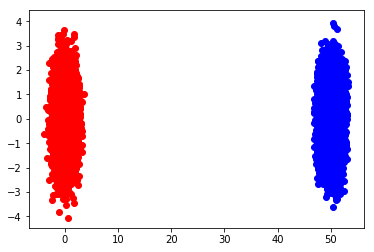

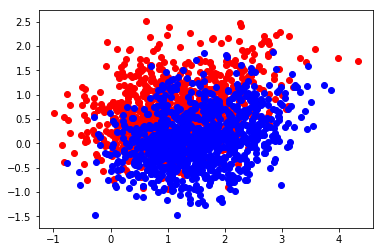

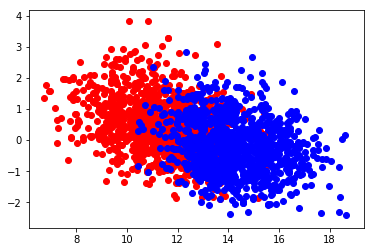

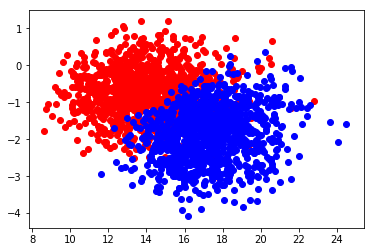

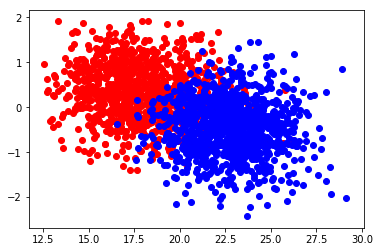

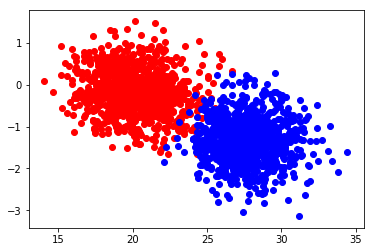

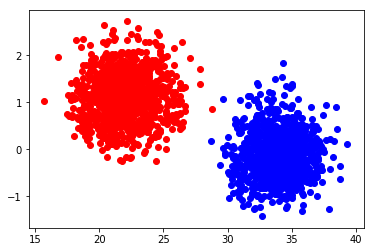

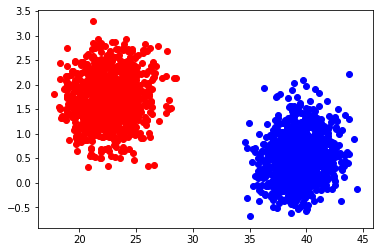

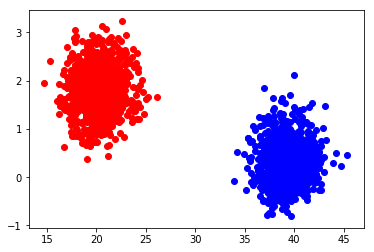

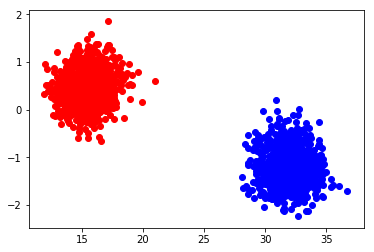

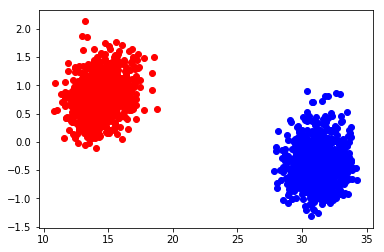

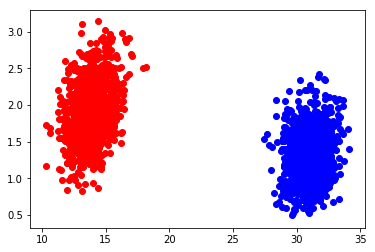

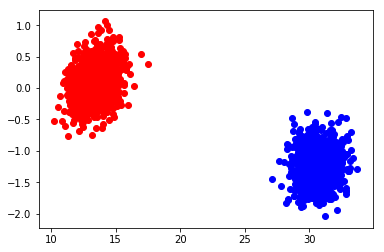

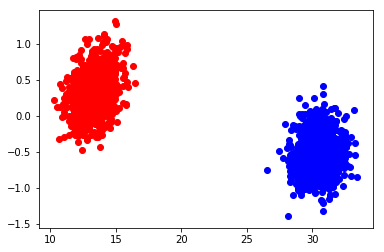

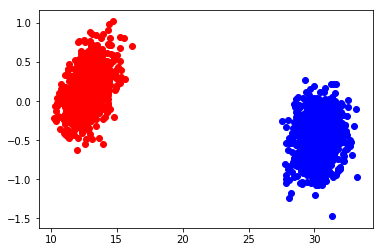

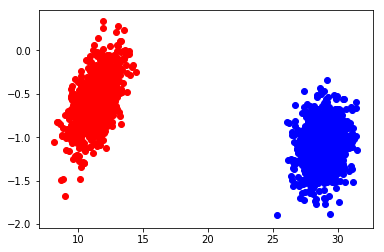

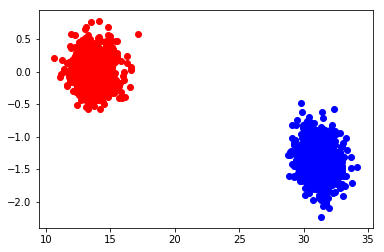

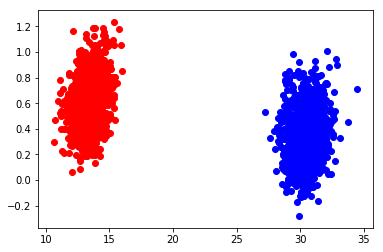

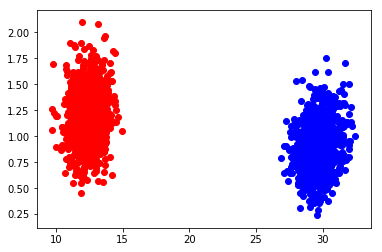

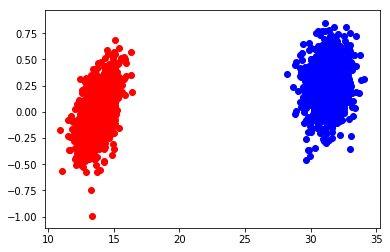

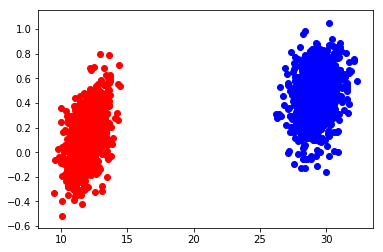

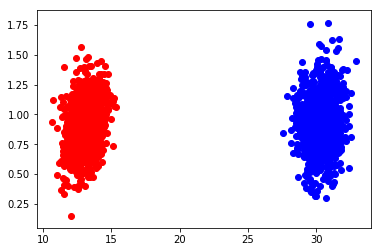

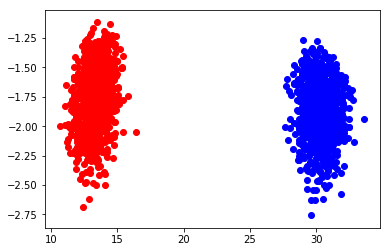

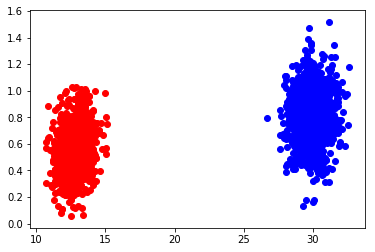

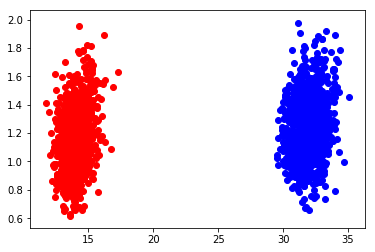

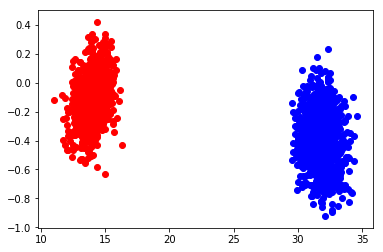

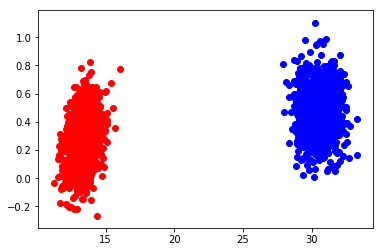

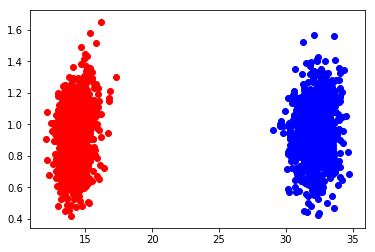

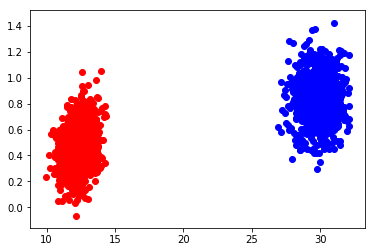

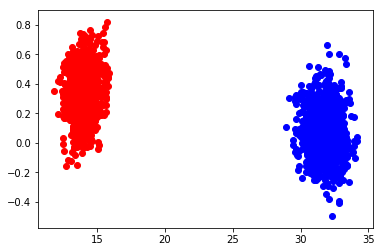

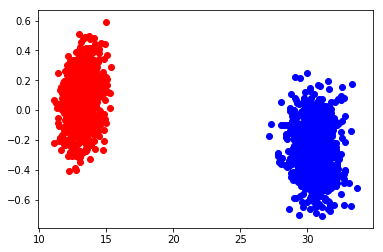

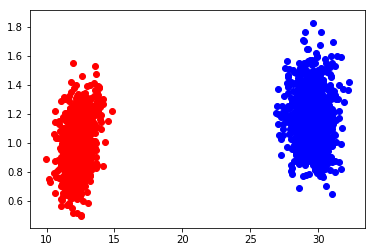

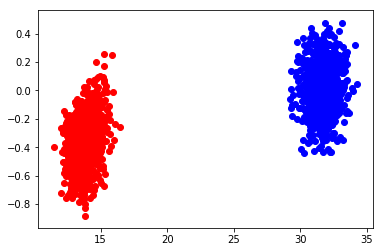

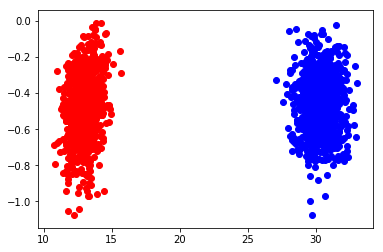

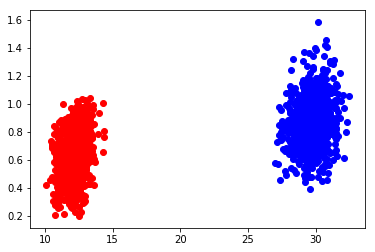

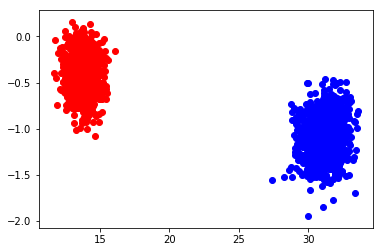

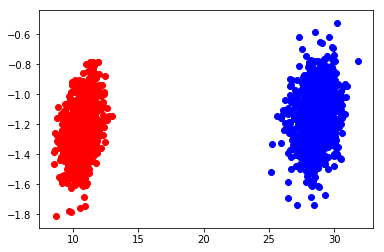

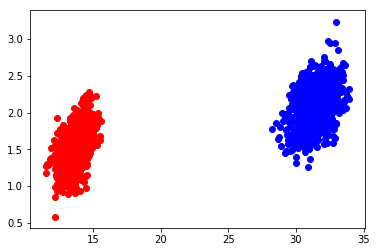

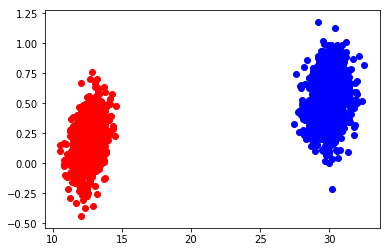

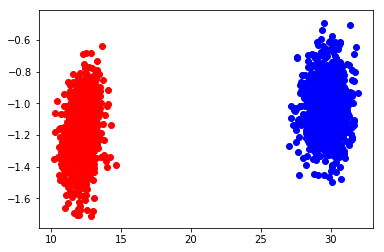

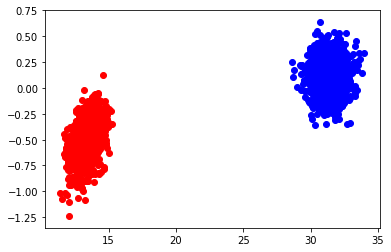

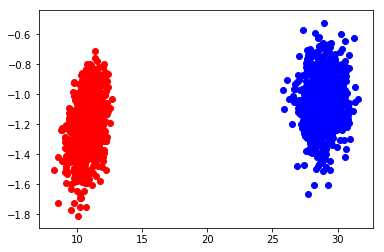

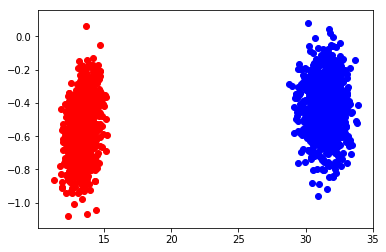

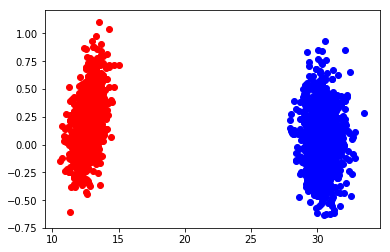

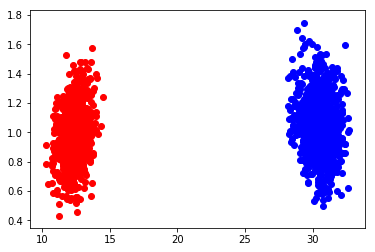

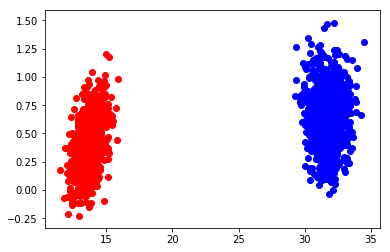

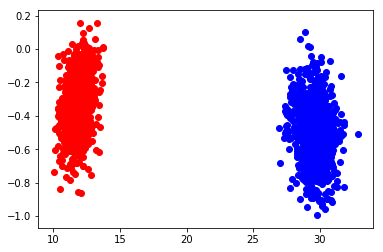

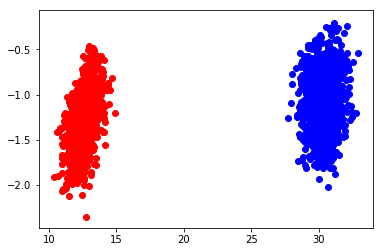

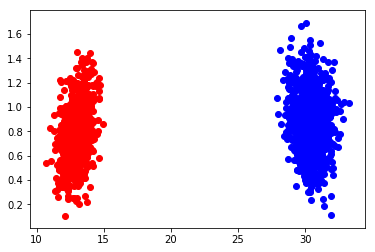

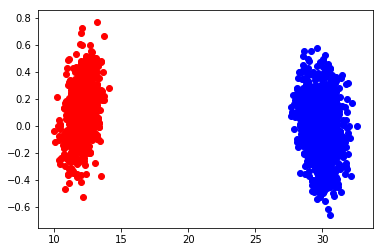

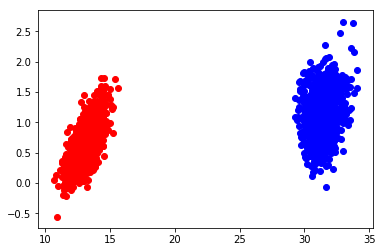

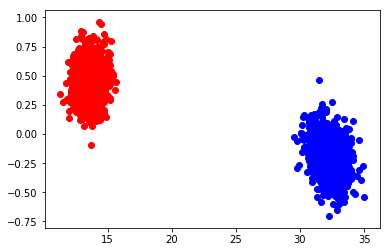

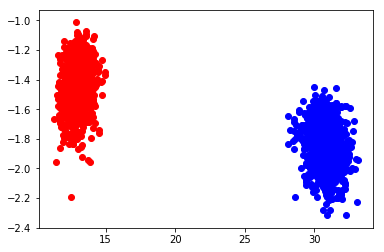

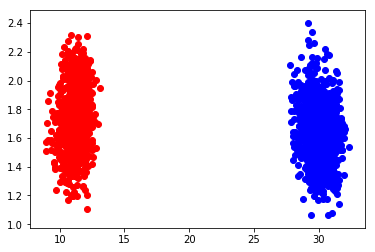

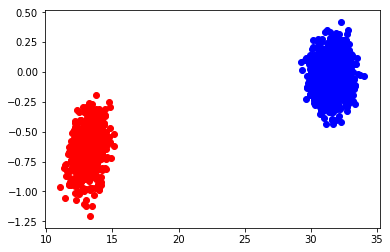

In [7]:
def train_gan():
  # Train Classifier
  
  # Initialize the variables (i.e. assign their default value)
  init = tf.global_variables_initializer()

  # Start training
  with tf.Session() as sess:

      # Run the initializer
      sess.run(init)

      sess.run(iter.initializer, feed_dict = {features: x_train, labels: y_train, batch_size: gan_batch_size, sample_size: 40000})

      # Train the Classifier First
      for i in range(4000):
        batch = sess.run(next_batch)
        model_optimizer.run(feed_dict={ x: batch[0], y: batch[1]})
        inverter_optimizer.run(feed_dict={ x: batch[0], y: batch[1]})
        if i % 500 == 0:
          train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1] })
          print('Epoch %d, training accuracy %g' % (i, train_accuracy))    

      test_acc, y_prediction = sess.run([accuracy, y_pred], feed_dict={x: x_train, y: y_train})
      print("test acc:", test_acc)

      cluster1 = []
      cluster2 = []
      cluster3 = []
      for i in range(0, num_data*NUM_LABEL):
        if y_prediction[i] == 0:
          cluster1.append(x_train[i])
        elif y_prediction[i] == 1:
          cluster2.append(x_train[i])
        else:
          cluster3.append(x_train[i])

      cluster1 = np.array(cluster1)
      cluster2 = np.array(cluster2)
      cluster3 = np.array(cluster3)
      print('cluster1: ', cluster1.shape, 'cluster2: ', cluster2.shape, 'cluster3:', cluster3.shape)
      plt.scatter(cluster1[:,0], cluster1[:,1],c='r')
      plt.scatter(cluster2[:,0], cluster2[:,1],c='b')
#       plt.scatter(cluster3[:,0], cluster3[:,1],c='g')
      plt.savefig('Classifier_plot')
      
      #Train GAN
      for i in range(1000000):      
        # Sample random noise 
        z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
       
        #! Train Discriminator
        train_disc.run(feed_dict={aux_x: aux_data,  gen_input: z})
#         if i % 5 == 0:
        train_gen.run(feed_dict={aux_x: aux_data,  gen_input: z})
       
        if i % 2000 == 0:
          gl,dl = sess.run([gen_loss, disc_loss], feed_dict={aux_x: aux_data,  gen_input: z})
          print('Epoch %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
          plot_gan_image('gan_out',str(i), sess)
      
      
if __name__ == '__main__':
  train_gan()